# Functional DPPM as a Prior on Coefficient Functions

This notebook simulates a **multi-task functional regression** problem with
coefficient functions that share a low-dimensional structure in function space.

Each task has a coefficient function β_r(t) that lies along one of a few
orthogonal functional "axes" g_k(t), with scalar weights z_r:
  
\[
\beta_r(t) = z_r g_{c_r}(t), \quad r = 1,\dots,T,\; k = 1,\dots,K_\star.
\]

We:
1. Simulate functional predictors x_i(t) and scalar responses y_i^{(r)}.
2. Estimate β̂_r(t) via simple functional OLS (basis representation).
3. Treat β̂_r(t) as our "data curves" and run a functional DPPM
   (EigenGP_DPPM_MCMC) on them.
4. Compare:
   - True vs DPPM-recovered coefficient functions.
   - True vs inferred clusters of tasks.
   - Alignment between true functional axes g_k(t) and inferred ones.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Import your existing classes from MCMC_Class.py
from MCMC_Class import EigenGP_DPPM_MCMC  # adjust name if needed


In [8]:
# Grid in time domain [0, 1]
m_grid = 100
t_grid = np.linspace(0.0, 1.0, m_grid)

# Number of basis functions for GP-based prior on functional axes
J_basis = 20

def fourier_basis(t, j):
    """
    Simple Fourier-like basis on [0, 1]:
    j = 0: constant
    odd j: sin(k*pi*t)
    even j: cos(k*pi*t)
    """
    if j == 0:
        return np.ones_like(t)
    k = (j + 1) // 2
    if j % 2 == 1:  # odd
        return np.sqrt(2) * np.sin(k * np.pi * t)
    else:  # even
        return np.sqrt(2) * np.cos(k * np.pi * t)

# Build basis matrix Phi (m_grid x J_basis)
Phi = np.zeros((m_grid, J_basis))
for j in range(J_basis):
    Phi[:, j] = fourier_basis(t_grid, j)

# Eigenvalues for the GP prior in this basis (decaying)
eigenvalues = 1.0 / (1.0 + np.arange(J_basis)**2)

print("Phi shape:", Phi.shape)
print("eigenvalues shape:", eigenvalues.shape)


Phi shape: (100, 20)
eigenvalues shape: (20,)


In [9]:
rng = np.random.default_rng(123)

# True number of functional axes
K_true = 3
T_tasks = 40   # number of tasks

# 1. Generate true axes g_k(t) via GP eigenbasis representation
B_true = rng.normal(scale=np.sqrt(eigenvalues)[None, :], size=(K_true, J_basis))
# g_k(t) = Phi @ b_k^T
G_true_curves = (Phi @ B_true.T)  # shape: (m_grid, K_true)

# Normalize to have unit L2 norm in discrete sense (for identifiability)
for k in range(K_true):
    norm_k = np.linalg.norm(G_true_curves[:, k]) * np.sqrt(1.0 / m_grid)
    G_true_curves[:, k] /= norm_k

# 2. Assign tasks to clusters
cluster_sizes = [T_tasks // K_true] * K_true
for i in range(T_tasks - sum(cluster_sizes)):
    cluster_sizes[i] += 1

c_true = np.concatenate([
    np.full(sz, k, dtype=int) for k, sz in enumerate(cluster_sizes)
])
rng.shuffle(c_true)

# 3. Generate scalar weights z_r for each task
cluster_means = np.array([1.0, -1.0, 0.5])
cluster_scales = np.array([0.6, 0.6, 0.6])

z_true = np.zeros(T_tasks)
for r in range(T_tasks):
    k = c_true[r]
    z_true[r] = rng.normal(loc=cluster_means[k], scale=cluster_scales[k])

# 4. Construct coefficient functions beta_r(t) = z_r * g_{c_r}(t)
Beta_true_curves = np.zeros((T_tasks, m_grid))
for r in range(T_tasks):
    k = c_true[r]
    Beta_true_curves[r, :] = z_true[r] * G_true_curves[:, k]

print("G_true_curves shape:", G_true_curves.shape)   # (m_grid, K_true)
print("Beta_true_curves shape:", Beta_true_curves.shape)  # (T_tasks, m_grid)
print("Cluster counts:", np.bincount(c_true))


G_true_curves shape: (100, 3)
Beta_true_curves shape: (40, 100)
Cluster counts: [14 13 13]


In [10]:
n_samples = 80    # number of observations per task
sigma_eps = 0.3   # observation noise

# Generate smooth functional predictors x_i(t)
# x_i(t) = sum_j a_{ij} psi_j(t) with psi_j similar to basis above
X_curves = np.zeros((n_samples, m_grid))

for i in range(n_samples):
    coeffs = rng.normal(scale=np.sqrt(eigenvalues))
    X_curves[i, :] = Phi @ coeffs

# Normalize predictors to keep scales moderate
X_curves /= np.max(np.abs(X_curves))

# Approximate inner product integral via Riemann sum
delta_t = t_grid[1] - t_grid[0]

# Responses: y_i^{(r)} = ∫ x_i(t) beta_r(t) dt + noise
Y = np.zeros((n_samples, T_tasks))
for r in range(T_tasks):
    for i in range(n_samples):
        inner_prod = np.sum(X_curves[i, :] * Beta_true_curves[r, :]) * delta_t
        Y[i, r] = inner_prod + sigma_eps * rng.normal()

print("X_curves shape:", X_curves.shape)   # (n_samples, m_grid)
print("Y shape:", Y.shape)                 # (n_samples, T_tasks)


X_curves shape: (80, 100)
Y shape: (80, 40)


In [11]:
# Compute A_{ij} = ∫ x_i(t) phi_j(t) dt ~ sum_l X(i,l) * Phi(l,j) * delta_t
A = np.einsum("il,lj->ij", X_curves, Phi) * delta_t  # shape (n_samples, J_basis)

# Estimate basis coefficients b_{jr} for each task via least squares
Bhat_basis = np.zeros((J_basis, T_tasks))

for r in range(T_tasks):
    y_r = Y[:, r]
    # Solve A b_r = y_r
    b_r, *_ = np.linalg.lstsq(A, y_r, rcond=None)
    Bhat_basis[:, r] = b_r

# Reconstruct coefficient curves beta_hat_r(t) = Phi @ b_r
Beta_hat_curves = (Phi @ Bhat_basis).T   # shape (T_tasks, m_grid)

print("Bhat_basis shape:", Bhat_basis.shape)
print("Beta_hat_curves shape:", Beta_hat_curves.shape)
ç

Bhat_basis shape: (20, 40)
Beta_hat_curves shape: (40, 100)


NameError: name 'ç' is not defined

In [12]:
# X_for_dppm: each row is one curve (task) over t_grid
X_for_dppm = Beta_hat_curves  # shape (T_tasks, m_grid)

# Truncation level for functional DPPM
K_trunc = 5

eigen_dppm = EigenGP_DPPM_MCMC(
    X=X_for_dppm,
    Phi=Phi,
    eigenvalues=eigenvalues ,
    K=K_trunc,
    alpha=1.0,
    a_tau=.1,
    b_tau=.1,
    a_sigma=.1,
    b_sigma=.1,
    sampler_type="collapsed",
    random_state=2025,
)

samples = eigen_dppm.run(
    n_iter=500,
    burn_in=250,
    thin=5,
    store_everything=True,
)

# Inspect keys in samples for debugging
print(samples.keys())


Iteration  0
Iteration  20
Iteration  40
Iteration  60
Iteration  80
Iteration  100
Iteration  120
Iteration  140
Iteration  160
Iteration  180
Iteration  200
Iteration  220
Iteration  240
Iteration  260
Iteration  280
Iteration  300
Iteration  320
Iteration  340
Iteration  360
Iteration  380
Iteration  400
Iteration  420
Iteration  440
Iteration  460
Iteration  480
dict_keys(['G', 'pi', 'tau2', 'sigma2', 'c', 'z'])


In [13]:
# Adjust key names below to match your implementation
G_samps = samples["G"]    # expect shape (n_kept, m_grid, K_trunc)
z_samps = samples["z"]    # expect shape (n_kept, T_tasks)
c_samps = samples["c"]    # expect shape (n_kept, T_tasks)

n_kept = G_samps.shape[0]

# Posterior samples for coefficient curves beta_r(t)
Beta_samps = np.zeros((n_kept, T_tasks, m_grid))

for s in range(n_kept):
    G_s = G_samps[s]           # (m_grid, K_trunc)
    z_s = z_samps[s]           # (T_tasks,)
    c_s = c_samps[s]           # (T_tasks,)
    for r in range(T_tasks):
        k = int(c_s[r])
        Beta_samps[s, r, :] = z_s[r] * G_s[:, k]

# Posterior mean
Beta_mean_curves = Beta_samps.mean(axis=0)   # shape (T_tasks, m_grid)

print("Beta_mean_curves shape:", Beta_mean_curves.shape)


Beta_mean_curves shape: (40, 100)


In [14]:
n_samples = 80    # number of observations per task
sigma_eps = 0.3   # observation noise

# Generate smooth functional predictors x_i(t)
# x_i(t) = sum_j a_{ij} psi_j(t) with psi_j similar to basis above
X_curves = np.zeros((n_samples, m_grid))

for i in range(n_samples):
    coeffs = rng.normal(scale=np.sqrt(eigenvalues))
    X_curves[i, :] = Phi @ coeffs

# Normalize predictors to keep scales moderate
X_curves /= np.max(np.abs(X_curves))

# Approximate inner product integral via Riemann sum
delta_t = t_grid[1] - t_grid[0]

# Responses: y_i^{(r)} = ∫ x_i(t) beta_r(t) dt + noise
Y = np.zeros((n_samples, T_tasks))
for r in range(T_tasks):
    for i in range(n_samples):
        inner_prod = np.sum(X_curves[i, :] * Beta_true_curves[r, :]) * delta_t
        Y[i, r] = inner_prod + sigma_eps * rng.normal()

print("X_curves shape:", X_curves.shape)   # (n_samples, m_grid)
print("Y shape:", Y.shape)                 # (n_samples, T_tasks)


X_curves shape: (80, 100)
Y shape: (80, 40)


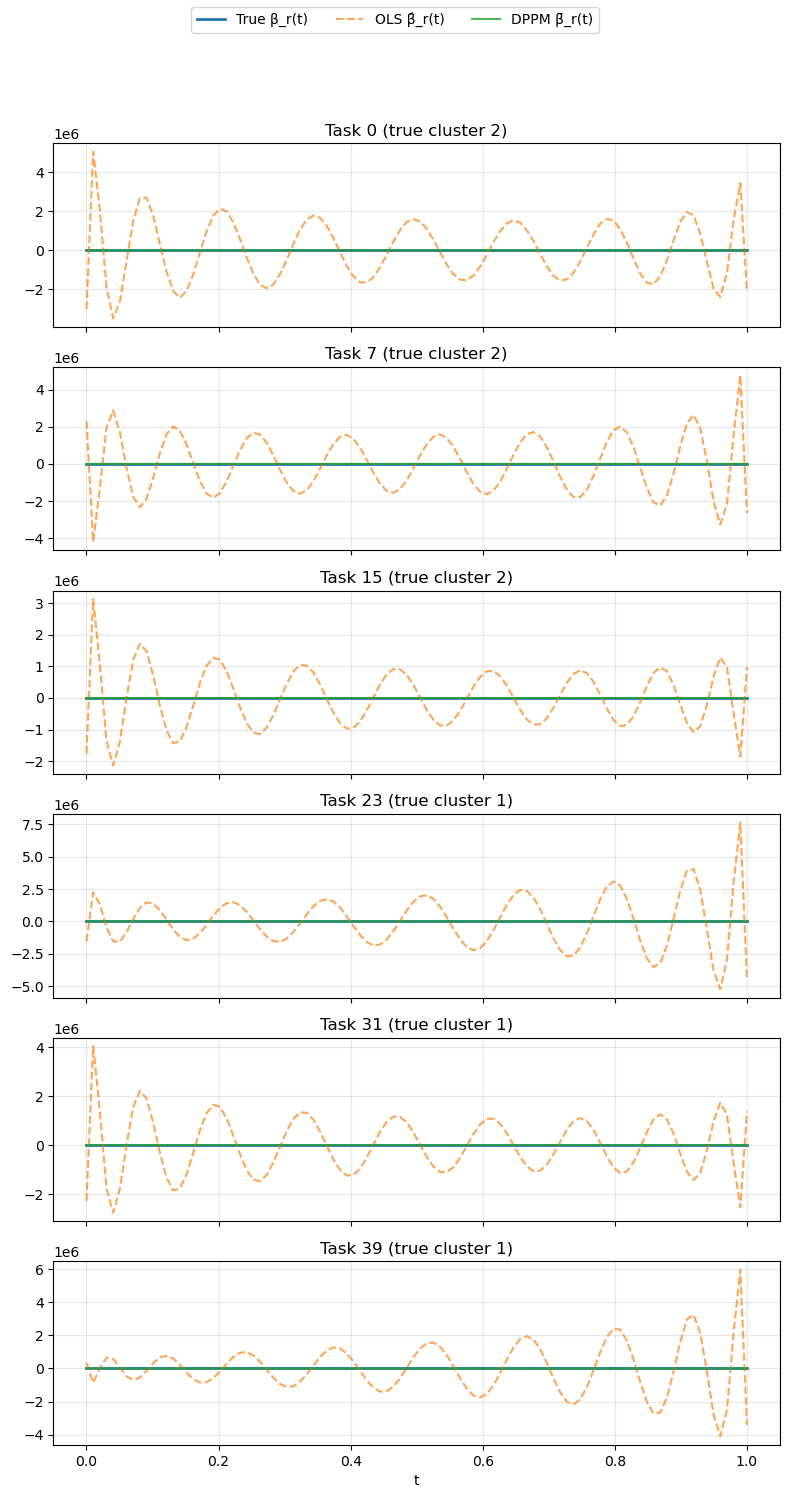

In [15]:
# Pick a few tasks to visualize
num_tasks_to_show = 6
tasks_to_show = np.linspace(0, T_tasks - 1, num_tasks_to_show, dtype=int)

fig, axes = plt.subplots(num_tasks_to_show, 1, figsize=(8, 2.5*num_tasks_to_show), sharex=True)

for ax, r in zip(axes, tasks_to_show):
    ax.plot(t_grid, Beta_true_curves[r, :], label="True β_r(t)", lw=2)
    ax.plot(t_grid, Beta_hat_curves[r, :], "--", label="OLS β̂_r(t)", alpha=0.7)
    ax.plot(t_grid, Beta_mean_curves[r, :], label="DPPM β̄_r(t)", alpha=0.8)
    ax.set_title(f"Task {r} (true cluster {c_true[r]})")
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("t")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


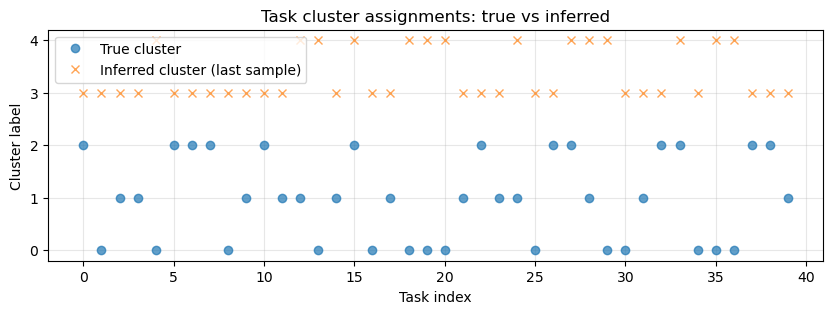

First 20 true vs inferred cluster labels:
Task  0: true=2, inferred=3
Task  1: true=0, inferred=3
Task  2: true=1, inferred=3
Task  3: true=1, inferred=3
Task  4: true=0, inferred=4
Task  5: true=2, inferred=3
Task  6: true=2, inferred=3
Task  7: true=2, inferred=3
Task  8: true=0, inferred=3
Task  9: true=1, inferred=3
Task 10: true=2, inferred=3
Task 11: true=1, inferred=3
Task 12: true=1, inferred=4
Task 13: true=0, inferred=4
Task 14: true=1, inferred=3
Task 15: true=2, inferred=4
Task 16: true=0, inferred=3
Task 17: true=1, inferred=3
Task 18: true=0, inferred=4
Task 19: true=0, inferred=4


In [16]:
c_samps = samples["c"]
c_hat_last = c_samps[-1]

plt.figure(figsize=(10, 3))
plt.plot(c_true, "o", label="True cluster", alpha=0.7)
plt.plot(c_hat_last, "x", label="Inferred cluster (last sample)", alpha=0.7)
plt.xlabel("Task index")
plt.ylabel("Cluster label")
plt.title("Task cluster assignments: true vs inferred")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("First 20 true vs inferred cluster labels:")
for r in range(min(20, T_tasks)):
    print(f"Task {r:2d}: true={c_true[r]}, inferred={c_hat_last[r]}")


Cosine similarity between true and inferred functional axes:
[[0.74498084 0.09753483 0.2491815  0.30771207 0.40027046]
 [0.68873733 0.03420965 0.51917556 0.31103056 0.28766056]
 [0.04856532 0.07519303 0.45525068 0.20172399 0.66299298]]


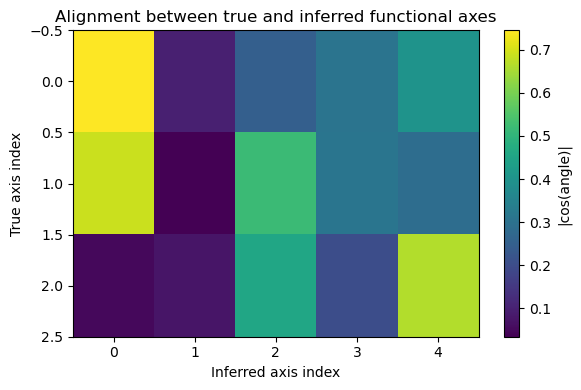

NameError: name 'v' is not defined

In [17]:
# Take last sampled G
G_last = G_samps[-1]   # (m_grid, K_trunc)

# Normalize inferred axes w.r.t discrete L2
for k in range(K_trunc):
    norm_k = np.linalg.norm(G_last[:, k]) * np.sqrt(delta_t)
    if norm_k > 0:
        G_last[:, k] /= norm_k

cos_sims = np.zeros((K_true, K_trunc))

for k_true in range(K_true):
    g_true = G_true_curves[:, k_true]
    for k_inf in range(K_trunc):
        g_inf = G_last[:, k_inf]
        num = np.trapz(g_true * g_inf, t_grid)
        den = np.sqrt(np.trapz(g_true**2, t_grid) * np.trapz(g_inf**2, t_grid))
        cos_sims[k_true, k_inf] = np.abs(num / den)

print("Cosine similarity between true and inferred functional axes:")
print(cos_sims)

plt.figure(figsize=(6, 4))
plt.imshow(cos_sims, cmap="viridis", aspect="auto")
plt.colorbar(label="|cos(angle)|")
plt.xlabel("Inferred axis index")
plt.ylabel("True axis index")
plt.title("Alignment between true and inferred functional axes")
plt.tight_layout()
plt.show()


# Image Clustering and Dimension Reduction with Functional DPPM

We treat each grayscale image as a function on a 1D grid (flattened pixel index)
and use a **functional Dirichlet Process Projection Model (DPPM)** to:

- learn a small set of functional axes \( g_k(t) \) over pixel positions,
- assign each image to one axis (cluster),
- obtain a low-dimensional representation \( z_i \) per image.

This is the functional analogue of a mixture-of-eigen-images model, with a
Dirichlet process prior over projection directions.


In [18]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Import your functional DPPM class
from MCMC_Class import EigenGP_DPPM_MCMC  # adjust name/path if needed


In [19]:
rng = np.random.default_rng(42)

img_h, img_w = 16, 16
num_pixels = img_h * img_w

n_per_cluster = 40
K_true = 3
n_images = K_true * n_per_cluster

def make_vertical_bar(h, w, col, thickness=2):
    img = np.zeros((h, w))
    c0 = max(0, col)
    c1 = min(w, col + thickness)
    img[:, c0:c1] = 1.0
    return img

def make_horizontal_bar(h, w, row, thickness=2):
    img = np.zeros((h, w))
    r0 = max(0, row)
    r1 = min(h, row + thickness)
    img[r0:r1, :] = 1.0
    return img

def make_diagonal(h, w, offset=0, thickness=1):
    img = np.zeros((h, w))
    for r in range(h):
        c = r + offset
        for t in range(-thickness, thickness+1):
            cc = c + t
            if 0 <= cc < w:
                img[r, cc] = 1.0
    return img

images = []
labels_true = []

# Cluster 0: vertical bars
for _ in range(n_per_cluster):
    col = rng.integers(low=4, high=12)
    base = make_vertical_bar(img_h, img_w, col, thickness=2)
    noise = 0.3 * rng.normal(size=(img_h, img_w))
    img = np.clip(base + noise, 0.0, 1.0)
    images.append(img)
    labels_true.append(0)

# Cluster 1: horizontal bars
for _ in range(n_per_cluster):
    row = rng.integers(low=4, high=12)
    base = make_horizontal_bar(img_h, img_w, row, thickness=2)
    noise = 0.3 * rng.normal(size=(img_h, img_w))
    img = np.clip(base + noise, 0.0, 1.0)
    images.append(img)
    labels_true.append(1)

# Cluster 2: diagonals
for _ in range(n_per_cluster):
    offset = rng.integers(low=-3, high=3)
    base = make_diagonal(img_h, img_w, offset=offset, thickness=1)
    noise = 0.3 * rng.normal(size=(img_h, img_w))
    img = np.clip(base + noise, 0.0, 1.0)
    images.append(img)
    labels_true.append(2)

images = np.stack(images, axis=0)          # (n_images, img_h, img_w)
labels_true = np.array(labels_true)        # (n_images,)

print("images shape:", images.shape)
print("labels_true counts:", np.bincount(labels_true))


images shape: (120, 16, 16)
labels_true counts: [40 40 40]


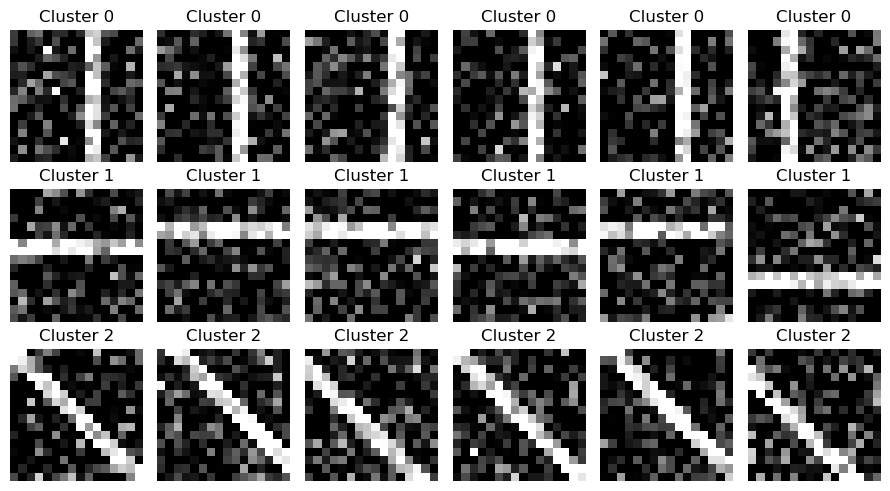

In [20]:
fig, axes = plt.subplots(3, 6, figsize=(9, 5))
axes = axes.ravel()

for k in range(3):
    idxs = np.where(labels_true == k)[0]
    chosen = rng.choice(idxs, size=6, replace=False)
    for j, idx in enumerate(chosen):
        ax = axes[k*6 + j]
        ax.imshow(images[idx], cmap="gray", vmin=0, vmax=1)
        ax.set_title(f"Cluster {k}")
        ax.axis("off")

plt.tight_layout()
plt.show()


In [34]:
# Flatten images: each image -> vector of length num_pixels
X_curves = images.reshape(n_images, num_pixels)  # (n_images, num_pixels)

print("X_curves shape:", X_curves.shape)

# Define 1D grid over [0,1] for pixel indices
t_grid = np.linspace(0.0, 1.0, num_pixels)

# Number of basis functions for functional prior
J_basis = 40

def fourier_basis(t, j):
    """
    Simple Fourier-ish basis on [0,1].
    j = 0: constant
    odd j: sin(k*pi*t)
    even j: cos(k*pi*t)
    """
    if j == 0:
        return np.ones_like(t)
    k = (j + 1) // 2
    if j % 2 == 1:
        return np.sqrt(2) * np.sin(k * np.pi * t)
    else:
        return np.sqrt(2) * np.cos(k * np.pi * t)

Phi = np.zeros((num_pixels, J_basis))
for j in range(J_basis):
    Phi[:, j] = fourier_basis(t_grid, j)

# Eigenvalues for GP prior (decaying)
eigenvalues = 1.0 / (1.0 + np.arange(J_basis)**2)

print("Phi shape:", Phi.shape)
print("eigenvalues shape:", eigenvalues.shape)


X_curves shape: (120, 256)
Phi shape: (256, 40)
eigenvalues shape: (40,)


In [35]:
# Flatten images: each image -> vector of length num_pixels
X_curves = images.reshape(n_images, num_pixels)  # (n_images, num_pixels)

print("X_curves shape:", X_curves.shape)

# Define 1D grid over [0,1] for pixel indices
t_grid = np.linspace(0.0, 1.0, num_pixels)

# Number of basis functions for functional prior
J_basis = 40

def fourier_basis(t, j):
    """
    Simple Fourier-ish basis on [0,1].
    j = 0: constant
    odd j: sin(k*pi*t)
    even j: cos(k*pi*t)
    """
    if j == 0:
        return np.ones_like(t)
    k = (j + 1) // 2
    if j % 2 == 1:
        return np.sqrt(2) * np.sin(k * np.pi * t)
    else:
        return np.sqrt(2) * np.cos(k * np.pi * t)

Phi = np.zeros((num_pixels, J_basis))
for j in range(J_basis):
    Phi[:, j] = fourier_basis(t_grid, j)

# Eigenvalues for GP prior (decaying)
eigenvalues = 1.0 / (1.0 + np.arange(J_basis)**2)

print("Phi shape:", Phi.shape)
print("eigenvalues shape:", eigenvalues.shape)


X_curves shape: (120, 256)
Phi shape: (256, 40)
eigenvalues shape: (40,)


In [36]:
# Truncation level for number of functional axes (projection directions)
K_trunc = 6

eigen_dppm = EigenGP_DPPM_MCMC(
    X=X_curves,           # (n_images, num_pixels)
    Phi=Phi,              # (num_pixels, J_basis)
    eigenvalues=eigenvalues,
    K=K_trunc,
    alpha=1.0,
    a_tau=2.0,
    b_tau=2.0,
    a_sigma=2.0,
    b_sigma=2.0,
    sampler_type="uncollapsed", 
    random_state=2025,
)

samples = eigen_dppm.run(
    n_iter=500,     # increase for more serious runs
    burn_in=250,
    thin=5,
    store_everything=True,
)

print("Available sample keys:", samples.keys())


Iteration  0
Iteration  20
Iteration  40
Iteration  60
Iteration  80
Iteration  100
Iteration  120
Iteration  140
Iteration  160
Iteration  180
Iteration  200
Iteration  220
Iteration  240
Iteration  260
Iteration  280
Iteration  300
Iteration  320
Iteration  340
Iteration  360
Iteration  380
Iteration  400
Iteration  420
Iteration  440
Iteration  460
Iteration  480
Available sample keys: dict_keys(['G', 'pi', 'tau2', 'sigma2', 'c', 'z'])


In [50]:
# Truncation level for number of functional axes (projection directions)
K_trunc = 6

eigen_dppm = EigenGP_DPPM_MCMC(
    X=X_curves,           # (n_images, num_pixels)
    Phi=Phi,              # (num_pixels, J_basis)
    eigenvalues=eigenvalues,
    K=K_trunc,
    alpha=1.0,
    a_tau=.1,
    b_tau=.1,
    a_sigma=.1,
    b_sigma=.1,
    sampler_type="uncollapsed",  # or "collapsed" if your code supports it
    random_state=2025,
)

samples = eigen_dppm.run(
    n_iter=500,     # increase for more serious runs
    burn_in=250,
    thin=5,
    store_everything=True,
)

print("Available sample keys:", samples.keys())


Iteration  0
Iteration  20
Iteration  40
Iteration  60
Iteration  80
Iteration  100
Iteration  120
Iteration  140
Iteration  160
Iteration  180
Iteration  200
Iteration  220
Iteration  240
Iteration  260
Iteration  280
Iteration  300
Iteration  320
Iteration  340
Iteration  360
Iteration  380
Iteration  400
Iteration  420
Iteration  440
Iteration  460
Iteration  480
Available sample keys: dict_keys(['G', 'pi', 'tau2', 'sigma2', 'c', 'z'])


In [51]:
G_samps = samples["G"]   # shape (n_kept, num_pixels, K_trunc)
z_samps = samples["z"]   # shape (n_kept, n_images)
c_samps = samples["c"]   # shape (n_kept, n_images)

n_kept = G_samps.shape[0]

# Use last sample for visualization
G_last = G_samps[-1]     # (num_pixels, K_trunc)
z_last = z_samps[-1]     # (n_images,)
c_last = c_samps[-1]     # (n_images,)

# Make sure each axis is L2-normalized (w.r.t discrete pixels)
delta_t = t_grid[1] - t_grid[0]
for k in range(K_trunc):
    norm_k = np.sqrt(np.sum(G_last[:, k]**2) * delta_t)
    if norm_k > 0:
        G_last[:, k] /= norm_k

# Reconstruct each image using 1D rank-1 projection: x_i ≈ z_i * g_{c_i}
X_recon = np.zeros_like(X_curves)
for i in range(n_images):
    k = int(c_last[i])
    X_recon[i, :] = z_last[i] * G_last[:, k]

# Reshape for visualization
images_recon = X_recon.reshape(n_images, img_h, img_w)
print("images_recon shape:", images_recon.shape)


images_recon shape: (120, 16, 16)


In [49]:
# Adjust key names below to match your implementation
G_samps = samples["G"]    # expect shape (n_kept, m_grid, K_trunc)
z_samps = samples["z"]    # expect shape (n_kept, T_tasks)
c_samps = samples["c"]    # expect shape (n_kept, T_tasks)

n_kept = G_samps.shape[0]

# Posterior samples for coefficient curves beta_r(t)
Beta_samps = np.zeros((n_kept, T_tasks, m_grid))

for s in range(n_kept):
    G_s = G_samps[s,:,::]          # (m_grid, K_trunc)
    z_s = z_samps[s]           # (T_tasks,)
    c_s = c_samps[s]           # (T_tasks,)
    for r in range(T_tasks):
        k = int(c_s[r])
        Beta_samps[s, r, :] = z_s[s] * G_s[:, k]

# Posterior mean
Beta_mean_curves = Beta_samps.mean(axis=0)   # shape (T_tasks, m_grid)

print("Beta_mean_curves shape:", Beta_mean_curves.shape)


ValueError: could not broadcast input array from shape (256,) into shape (100,)

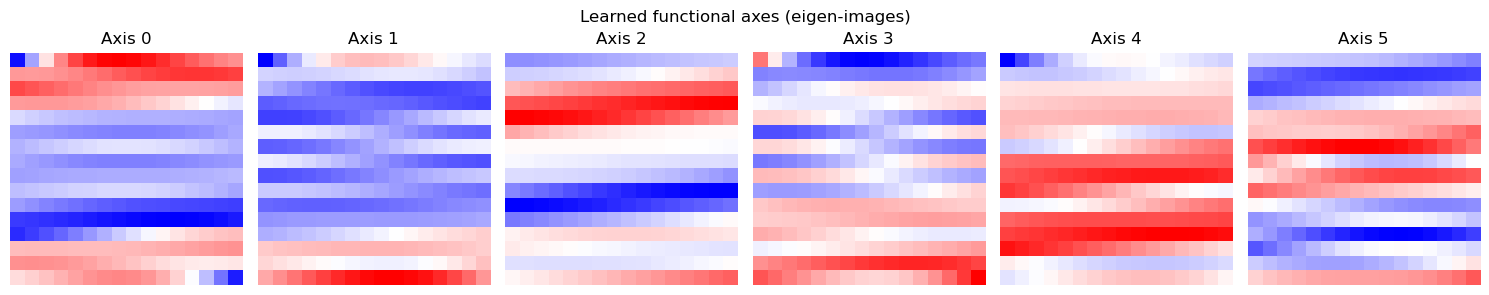

In [52]:
fig, axes = plt.subplots(1, K_trunc, figsize=(2.5*K_trunc, 3))

for k in range(K_trunc):
    ax = axes[k]
    axis_img = G_last[:, k].T.reshape(img_h, img_w)
    ax.imshow(axis_img, cmap="bwr")
    ax.set_title(f"Axis {k}")
    ax.axis("off")

plt.suptitle("Learned functional axes (eigen-images)")
plt.tight_layout()
plt.show()





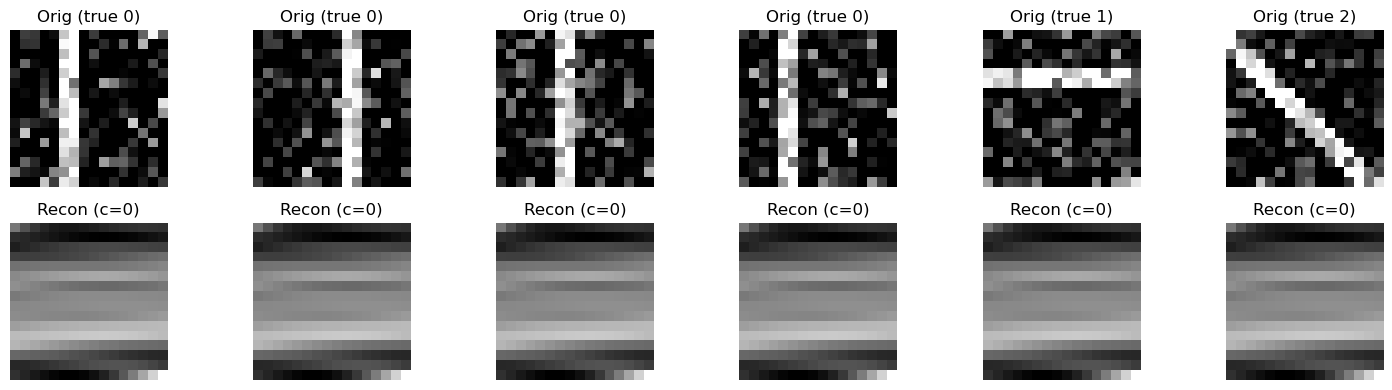

In [43]:
num_show = 6
idxs = rng.choice(n_images, size=num_show, replace=False)

fig, axes = plt.subplots(2, num_show, figsize=(2.5*num_show, 4))

for j, idx in enumerate(idxs):
    ax0 = axes[0, j]
    ax1 = axes[1, j]
    ax0.imshow(images[idx], cmap="gray", vmin=0, vmax=1)
    ax0.set_title(f"Orig (true {labels_true[idx]})")
    ax0.axis("off")
    
    ax1.imshow(images_recon[idx], cmap="gray")
    ax1.set_title(f"Recon (c={c_last[idx]})")
    ax1.axis("off")

plt.tight_layout()
plt.show()


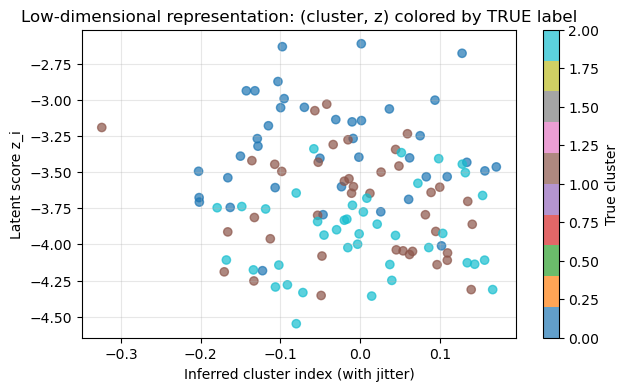

In [44]:
plt.figure(figsize=(7, 4))

x_coords = c_last + 0.1 * rng.normal(size=n_images)  # jitter cluster index a bit
plt.scatter(x_coords, z_last, c=labels_true, cmap="tab10", alpha=0.7)
plt.xlabel("Inferred cluster index (with jitter)")
plt.ylabel("Latent score z_i")
plt.title("Low-dimensional representation: (cluster, z) colored by TRUE label")
plt.grid(alpha=0.3)
cbar = plt.colorbar()
cbar.set_label("True cluster")
plt.show()


In [53]:
print("First 40 images: true vs inferred cluster")
for i in range(min(40, n_images)):
    print(f"i={i:2d}, true={labels_true[i]}, inferred={c_last[i]}")


First 40 images: true vs inferred cluster
i= 0, true=0, inferred=0
i= 1, true=0, inferred=0
i= 2, true=0, inferred=0
i= 3, true=0, inferred=0
i= 4, true=0, inferred=0
i= 5, true=0, inferred=0
i= 6, true=0, inferred=0
i= 7, true=0, inferred=0
i= 8, true=0, inferred=0
i= 9, true=0, inferred=0
i=10, true=0, inferred=0
i=11, true=0, inferred=0
i=12, true=0, inferred=0
i=13, true=0, inferred=0
i=14, true=0, inferred=0
i=15, true=0, inferred=0
i=16, true=0, inferred=0
i=17, true=0, inferred=0
i=18, true=0, inferred=0
i=19, true=0, inferred=0
i=20, true=0, inferred=0
i=21, true=0, inferred=0
i=22, true=0, inferred=0
i=23, true=0, inferred=0
i=24, true=0, inferred=0
i=25, true=0, inferred=0
i=26, true=0, inferred=0
i=27, true=0, inferred=0
i=28, true=0, inferred=0
i=29, true=0, inferred=0
i=30, true=0, inferred=0
i=31, true=0, inferred=0
i=32, true=0, inferred=0
i=33, true=0, inferred=0
i=34, true=0, inferred=0
i=35, true=0, inferred=0
i=36, true=0, inferred=0
i=37, true=0, inferred=0
i=38, tr

In [54]:
# build 1D basis
Phi_s = basis_s(s_grid)   # shape (H, Js)
Phi_t = basis_t(t_grid)   # shape (W, Jt)

# 2D tensor basis (Kronecker product)
Phi_2D = np.kron(Phi_s, Phi_t)  # (H*W, Js*Jt)

# reshape eigenvalues accordingly
eigenvalues_2D = np.outer(lambda_s, lambda_t).ravel()

NameError: name 'basis_s' is not defined

In [56]:
# ============================================================
# 2D Functional DPPM on scikit-learn sample images
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
from scipy.linalg import svd

# Load the MCMC class (assumes MCMC_Class.py is in the working directory)
from MCMC_Class import DPPM_MCMC

# ============================================================
# 1. Load and preprocess images
# ============================================================

# Load sample images from sklearn
images = load_sample_images()
X_raw = np.array(images.images)  # shape: (2, height, width, 3) - two color images

# Convert to grayscale by averaging RGB channels
X_gray = X_raw.mean(axis=-1)  # shape: (2, height, width)

print(f"Loaded {X_gray.shape[0]} images of shape {X_gray.shape[1:]}") 

# Flatten images: each image becomes a row vector
n_images = X_gray.shape[0]
height, width = X_gray.shape[1], X_gray.shape[2]
n_pixels = height * width

X_flat = X_gray.reshape(n_images, -1)  # shape: (n_images, n_pixels)

# Normalize to zero mean and unit variance
X_mean = X_flat.mean(axis=0, keepdims=True)
X_std = X_flat.std(axis=0, keepdims=True) + 1e-8
X_normalized = (X_flat - X_mean) / X_std

print(f"Flattened data shape: {X_flat.shape}")
print(f"Data range: [{X_normalized.min():.2f}, {X_normalized.max():.2f}]")

# ============================================================
# 2. Create eigenfunction basis via SVD
# ============================================================

J = 50  # number of basis functions to retain

# Compute SVD: X = U S V^T
U, S, Vt = svd(X_normalized, full_matrices=False)

# Phi = first J columns of V
Phi = Vt.T[:, :J]  # shape: (n_pixels, J)

# Eigenvalues for GP prior
eigenvalues = (S[:J] ** 2) / (n_images - 1)

print(f"Basis Phi shape: {Phi.shape}")
print(f"Eigenvalues (first 10): {eigenvalues[:10]}")

# ============================================================
# 3. Set up and run the DPPM MCMC sampler
# ============================================================

K = 25 # number of mixture components (projection axes)

# Hyperparameters
alpha = 1.0       # Dirichlet concentration
a_tau, b_tau = .1, .1    # Inverse-Gamma for tau^2
a_sigma, b_sigma = .1,.1 # Inverse-Gamma for sigma^2

# Initialize the DPPM MCMC sampler
sampler = DPPM_MCMC(
    X=X_normalized,
    K=K,
    alpha=alpha,
    a_tau=a_tau,
    b_tau=b_tau,
    a_sigma=a_sigma,
    b_sigma=b_sigma,
    sampler_type="uncollapsed",
    G_update="mh",
    step_size_G=0.05,
    random_state=42
)

print(f"\nRunning MCMC with K={K} components...")

# Run MCMC
n_iter = 2000
burn_in = 1000
thin = 2

samples = sampler.run(n_iter=n_iter, burn_in=burn_in, thin=thin)

n_samples = samples["G"].shape[0]
print(f"Collected {n_samples} posterior samples after burn-in and thinning.")

# ============================================================
# 4. Posterior summary and visualization
# ============================================================

# Compute posterior means
G_mean = samples["G"].mean(axis=0)  # shape: (n_pixels, K)
pi_mean = samples["pi"].mean(axis=0)
tau2_mean = samples["tau2"].mean(axis=0)
sigma2_mean = samples["sigma2"].mean()

print(f"\nPosterior means:")
print(f"  Mixture weights pi: {pi_mean}")
print(f"  Component variances tau^2: {tau2_mean}")
print(f"  Noise variance sigma^2: {sigma2_mean:.4f}")

# Posterior mode cluster assignment
c_mode = np.round(samples["c"].mean(axis=0)).astype(int)
print(f"  Modal cluster assignments: {c_mode}")

# Visualize the learned projection axes
fig, axes = plt.subplots(1, K, figsize=(12, 4))
fig.suptitle("Learned Projection Axes (Posterior Mean)", fontsize=14)

for k in range(K):
    g_k = G_mean[:, k].reshape(height, width)
    axes[k].imshow(g_k, cmap='coolwarm', aspect='auto')
    axes[k].set_title(f"Axis {k+1}\nweight={pi_mean[k]:.2f}")
    axes[k].axis('off')

plt.tight_layout()
plt.savefig('dppm_projection_axes.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nProjection axes saved to 'dppm_projection_axes.png'")

# ============================================================
# 5. Reconstruct images using the learned model
# ============================================================

# Reconstruction: X_i ≈ z_i * g_{c_i}
z_mean = samples["z"].mean(axis=0)  # shape: (n_images,)

X_reconstructed = np.zeros_like(X_normalized)
for i in range(n_images):
    k = c_mode[i]
    X_reconstructed[i] = z_mean[i] * G_mean[:, k]

# Denormalize
X_reconstructed_denorm = X_reconstructed * X_std + X_mean

# Reshape back to images
reconstructed_images = X_reconstructed_denorm.reshape(n_images, height, width)
original_images = X_flat.reshape(n_images, height, width)

# Plot original vs reconstructed
fig, axes = plt.subplots(2, n_images, figsize=(10, 6))
fig.suptitle("Original vs. DPPM Reconstructed Images", fontsize=14)

for i in range(n_images):
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].set_title(f"Reconstructed {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('dppm_reconstruction.png', dpi=150, bbox_inches='tight')
plt.show()

print("Reconstruction comparison saved to 'dppm_reconstruction.png'")

# ============================================================
# 6. Trace plots for MCMC diagnostics
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("MCMC Trace Plots", fontsize=14)

# Trace of sigma^2
axes[0, 0].plot(samples["sigma2"])
axes[0, 0].set_title("Noise variance $\\sigma^2$")
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].set_ylabel("$\\sigma^2$")

# Trace of pi (mixture weights)
for k in range(K):
    axes[0, 1].plot(samples["pi"][:, k], label=f"$\\pi_{{{k+1}}}$")
axes[0, 1].set_title("Mixture weights $\\pi$")
axes[0, 1].set_xlabel("Iteration")
axes[0, 1].set_ylabel("$\\pi_k$")
axes[0, 1].legend()

# Trace of tau^2
for k in range(K):
    axes[1, 0].plot(samples["tau2"][:, k], label=f"$\\tau^2_{{{k+1}}}$")
axes[1, 0].set_title("Component variances $\\tau^2$")
axes[1, 0].set_xlabel("Iteration")
axes[1, 0].set_ylabel("$\\tau^2_k$")
axes[1, 0].legend()

# Distribution of cluster assignments (posterior)
c_counts = np.zeros((n_samples, K))
for s in range(n_samples):
    for k in range(K):
        c_counts[s, k] = (samples["c"][s] == k).sum()

for k in range(K):
    axes[1, 1].plot(c_counts[:, k], label=f"Cluster {k+1}")
axes[1, 1].set_title("Cluster assignment counts")
axes[1, 1].set_xlabel("Iteration")
axes[1, 1].set_ylabel("Count")
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('dppm_traces.png', dpi=150, bbox_inches='tight')
plt.show()

print("MCMC trace plots saved to 'dppm_traces.png'")

# ============================================================
# 7. Summary statistics and reconstruction error
# ============================================================

# Compute reconstruction error (MSE)
reconstruction_error = np.mean((X_normalized - X_reconstructed) ** 2)
print(f"\nReconstruction MSE: {reconstruction_error:.4f}")

# Posterior credible intervals for mixture weights
pi_lower = np.percentile(samples["pi"], 2.5, axis=0)
pi_upper = np.percentile(samples["pi"], 97.5, axis=0)

print(f"\n95% Credible intervals for mixture weights pi:")
for k in range(K):
    print(f"  π_{k+1}: [{pi_lower[k]:.3f}, {pi_upper[k]:.3f}]")

print("\n=== DPPM analysis complete ===")


Loaded 2 images of shape (427, 640)
Flattened data shape: (2, 273280)
Data range: [-1.00, 1.00]
Basis Phi shape: (273280, 2)
Eigenvalues (first 10): [5.45957999e+05 1.57894235e-20]

Running MCMC with K=25 components...
Iteration  0
Iteration  20
Iteration  40
Iteration  60
Iteration  80
Iteration  100
Iteration  120
Iteration  140
Iteration  160
Iteration  180
Iteration  200
Iteration  220
Iteration  240
Iteration  260
Iteration  280
Iteration  300
Iteration  320
Iteration  340
Iteration  360
Iteration  380
Iteration  400
Iteration  420
Iteration  440
Iteration  460
Iteration  480
Iteration  500
Iteration  520
Iteration  540
Iteration  560
Iteration  580
Iteration  600
Iteration  620
Iteration  640
Iteration  660
Iteration  680
Iteration  700
Iteration  720
Iteration  740
Iteration  760
Iteration  780
Iteration  800
Iteration  820
Iteration  840
Iteration  860
Iteration  880
Iteration  900
Iteration  920
Iteration  940
Iteration  960
Iteration  980
Iteration  1000
Iteration  1020
Itera

KeyboardInterrupt: 

In [76]:
import numpy as np
from numpy.linalg import eigh
from scipy.optimize import minimize

# 1D RBF kernel for rows/cols
def rbf_kernel(x, length_scale):
    dx = x[:, None] - x[None, :]
    return np.exp(-0.5 * (dx / length_scale) ** 2)

# Helper: for given (ls_row, ls_col), build 1D kernels and eigendecomps
def build_kernels_and_eigs(ls_row, ls_col, height, width):
    row_coords = np.linspace(0.0, 1.0, height)
    col_coords = np.linspace(0.0, 1.0, width)

    K_row = rbf_kernel(row_coords, ls_row)
    K_col = rbf_kernel(col_coords, ls_col)

    # Eigen-decomp (symmetric PSD)
    eigvals_row, eigvecs_row = eigh(K_row)
    eigvals_col, eigvecs_col = eigh(K_col)

    # Sort descending
    idx_row = np.argsort(eigvals_row)[::-1]
    idx_col = np.argsort(eigvals_col)[::-1]

    eigvals_row = eigvals_row[idx_row]
    eigvecs_row = eigvecs_row[:, idx_row]
    eigvals_col = eigvals_col[idx_col]
    eigvecs_col = eigvecs_col[:, idx_col]

    return eigvals_row, eigvecs_row, eigvals_col, eigvecs_col


In [77]:
# X_normalized: (n_images, n_pixels) with column-major vec of (height x width)
n_images = X_normalized.shape[0]
n_pixels = height * width
tolerance = 1e-6

def neg_log_marginal_gp(theta):
    """
    Negative log marginal likelihood for a separable GP:
        K = K_col(ls_col) ⊗ K_row(ls_row) + sigma^2 I
    assuming zero mean and images stacked in X_normalized.
    
    theta = [log_ls_row, log_ls_col, log_sigma2]
    """
    log_ls_row, log_ls_col, log_sigma2 = theta
    ls_row = np.exp(log_ls_row)
    ls_col = np.exp(log_ls_col)
    sigma2 = np.exp(log_sigma2)

    # Build 1D kernels and eigendecompositions
    eigvals_row, eigvecs_row, eigvals_col, eigvecs_col = build_kernels_and_eigs(
        ls_row, ls_col, height, width
    )

    # 2D eigenvalues of K (without noise)
    # K = K_col ⊗ K_row, so lambda_ij = eigvals_row[i] * eigvals_col[j]
    lam_2d = np.outer(eigvals_row, eigvals_col)  # shape (height, width)
    lam_2d = lam_2d + sigma2                     # add noise variance

    # Avoid numerical issues
    lam_2d = np.maximum(lam_2d, tolerance)

    # Transform images into the eigenbasis U_row ⊗ U_col.
    # For each image M (height x width), we compute:
    #   M_tilde = U_row^T M U_col   (so vec(M_tilde) are the coefficients)
    quad_term = 0.0

    for i in range(n_images):
        M = X_normalized[i].reshape(height, width, order="F")
        M_tilde = eigvecs_row.T @ M @ eigvecs_col   # shape (height, width)
        quad_term += np.sum((M_tilde ** 2) / lam_2d)

    # log|K| = sum_ij log(lambda_ij)
    logdet_K = np.sum(np.log(lam_2d))

    # GP marginal log-likelihood for n_images independent draws
    # p(X) = ∏_i N(0, K)
    log_like = -0.5 * quad_term \
               -0.5 * n_images * logdet_K \
               -0.5 * n_images * n_pixels * np.log(2 * np.pi)

    return -log_like  # negative for minimization


In [78]:
# Initial guesses (log-space)
init_ls_row = 0.3
init_ls_col = 0.3
init_sigma2 = 0.1

theta0 = np.log([init_ls_row, init_ls_col, init_sigma2])

print("Optimizing GP hyperparameters (ls_row, ls_col, sigma2) via ML...")

res = minimize(
    neg_log_marginal_gp,
    theta0,
    method="L-BFGS-B",
    options={"maxiter": 50, "disp": True}
)

print("\nOptimization result:", res.message)
print("Final negative log-likelihood:", res.fun)

log_ls_row_hat, log_ls_col_hat, log_sigma2_hat = res.x
ls_row_hat = float(np.exp(log_ls_row_hat))
ls_col_hat = float(np.exp(log_ls_col_hat))
sigma2_hat = float(np.exp(log_sigma2_hat))

print(f"\nML estimates:")
print(f"  ls_row  = {ls_row_hat:.4f}")
print(f"  ls_col  = {ls_col_hat:.4f}")
print(f"  sigma^2 = {sigma2_hat:.6f}")


Optimizing GP hyperparameters (ls_row, ls_col, sigma2) via ML...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93389D+05    |proj g|=  6.35199D+05

At iterate    1    f=  4.81194D+05    |proj g|=  6.21988D+04

At iterate    2    f=  4.72080D+05    |proj g|=  4.16796D+04

At iterate    3    f=  4.60782D+05    |proj g|=  3.10915D+04

At iterate    4    f=  3.72631D+05    |proj g|=  9.38723D+04

At iterate    5    f=  3.41175D+05    |proj g|=  4.62445D+04

At iterate    6    f=  3.33997D+05    |proj g|=  1.46586D+04

At iterate    7    f=  3.31329D+05    |proj g|=  6.46892D+03

At iterate    8    f=  3.31164D+05    |proj g|=  4.54007D+03

At iterate    9    f=  3.31046D+05    |proj g|=  4.72454D+02

At iterate   10    f=  3.31043D+05    |proj g|=  5.12111D+01

At iterate   11    f=  3.31043D+05    |proj g|=  5.98957D+00

Optimization result:
At iterate   12    f=  3.31043D+05    |proj g|=  3.89991D-01

     

In [83]:
# Rebuild eigenpairs using ML length scales
eigvals_row_hat, eigvecs_row_hat, eigvals_col_hat, eigvecs_col_hat = build_kernels_and_eigs(
    ls_row_hat, ls_col_hat, height, width
)

# Choose how many basis functions to retain in each direction
J_row = 10
J_col = 10

Phi_row = eigvecs_row_hat[:, :J_row]           # (height, J_row)
Phi_col = eigvecs_col_hat[:, :J_col]           # (width, J_col)
lambda_row = eigvals_row_hat[:J_row]
lambda_col = eigvals_col_hat[:J_col]

# 2D basis via Kronecker product (matches column-major ordering)
Phi_2D = np.kron(Phi_col, Phi_row)            # shape (n_pixels, J_row*J_col)


# 2D eigenvalues for GP prior in this basis
eigenvalues_2D = np.kron(lambda_col, lambda_row)  # shape (J_row*J_col,)

print(f"2D basis Phi_2D shape: {Phi_2D.shape} (should be {height*width} x {J_row*J_col})")
print("First 10 2D eigenvalues:", eigenvalues_2D[:10])


2D basis Phi_2D shape: (273280, 100) (should be 273280 x 100)
First 10 2D eigenvalues: [128.23832009 128.07698984 127.80855781 127.43369959 126.95335699
 126.36873418 125.68129255 124.89274468 124.00504721 123.02039272]


In [85]:
# ============================================================
# Principal run cell: 2D separable GP ML + functional DPPM
# on the two sklearn sample images
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
from numpy.linalg import eigh
from scipy.optimize import minimize

from MCMC_Class import EigenGP_DPPM_MCMC   # functional DPPM class

# ------------------------------------------------------------
# 1. Load and preprocess images
# ------------------------------------------------------------
images = load_sample_images()
X_raw = np.array(images.images)          # (2, H, W, 3)
X_gray = X_raw.mean(axis=-1)             # (2, H, W) grayscale

n_images, height, width = X_gray.shape
n_pixels = height * width

print(f"Loaded {n_images} images of shape {height}x{width}")

# Flatten in column-major order so that vec uses (row, col) with p = r + H*c
X_flat = X_gray.reshape(n_images, -1, order="F")

# Normalize per pixel
X_mean = X_flat.mean(axis=0, keepdims=True)
X_std = X_flat.std(axis=0, keepdims=True) + 1e-8
X_normalized = (X_flat - X_mean) / X_std

print("X_normalized shape:", X_normalized.shape)

# ------------------------------------------------------------
# 2. Separable 2D GP ML: fit ls_row, ls_col, sigma^2 by ML
# ------------------------------------------------------------
def rbf_kernel(x, length_scale):
    dx = x[:, None] - x[None, :]
    return np.exp(-0.5 * (dx / length_scale) ** 2)

def build_kernels_and_eigs(ls_row, ls_col, H, W):
    row_coords = np.linspace(0.0, 1.0, H)
    col_coords = np.linspace(0.0, 1.0, W)

    K_row = rbf_kernel(row_coords, ls_row)
    K_col = rbf_kernel(col_coords, ls_col)

    eigvals_row, eigvecs_row = eigh(K_row)
    eigvals_col, eigvecs_col = eigh(K_col)

    # Sort descending
    idx_row = np.argsort(eigvals_row)[::-1]
    idx_col = np.argsort(eigvals_col)[::-1]
    eigvals_row = eigvals_row[idx_row]
    eigvecs_row = eigvecs_row[:, idx_row]
    eigvals_col = eigvals_col[idx_col]
    eigvecs_col = eigvecs_col[:, idx_col]

    return eigvals_row, eigvecs_row, eigvals_col, eigvecs_col

tolerance = 1e-6

def neg_log_marginal_gp(theta):
    """
    Negative log marginal likelihood for:
        vec(image) ~ N(0, K_col⊗K_row + sigma^2 I)
    with separable RBF kernels in row and column.
    theta = [log_ls_row, log_ls_col, log_sigma2]
    """
    log_ls_row, log_ls_col, log_sigma2 = theta
    ls_row = np.exp(log_ls_row)
    ls_col = np.exp(log_ls_col)
    sigma2 = np.exp(log_sigma2)

    eigvals_row, eigvecs_row, eigvals_col, eigvecs_col = build_kernels_and_eigs(
        ls_row, ls_col, height, width
    )

    # Eigenvalues of K_col⊗K_row
    lam_2d = np.outer(eigvals_row, eigvals_col) + sigma2    # (H, W)
    lam_2d = np.maximum(lam_2d, tolerance)

    quad_term = 0.0
    for i in range(n_images):
        M = X_normalized[i].reshape(height, width, order="F")
        # transform to eigenbasis
        M_tilde = eigvecs_row.T @ M @ eigvecs_col           # (H, W)
        quad_term += np.sum((M_tilde ** 2) / lam_2d)

    logdet_K = np.sum(np.log(lam_2d))
    log_like = -0.5 * quad_term \
               -0.5 * n_images * logdet_K \
               -0.5 * n_images * n_pixels * np.log(2 * np.pi)

    return -log_like

# Initial guess
theta0 = np.log([0.3, 0.3, 0.1])  # [ls_row, ls_col, sigma2] in log-space

print("\nOptimizing GP hyperparameters (ls_row, ls_col, sigma2) via ML...")
res = minimize(
    neg_log_marginal_gp,
    theta0,
    method="L-BFGS-B",
    options={"maxiter": 30, "disp": True}
)

log_ls_row_hat, log_ls_col_hat, log_sigma2_hat = res.x
ls_row_hat = float(np.exp(log_ls_row_hat))
ls_col_hat = float(np.exp(log_ls_col_hat))
sigma2_hat = float(np.exp(log_sigma2_hat))

print("\nML hyperparameters:")
print(f"  ls_row  = {ls_row_hat:.4f}")
print(f"  ls_col  = {ls_col_hat:.4f}")
print(f"  sigma^2 = {sigma2_hat:.6f}")

# ------------------------------------------------------------
# 3. Build 2D GP eigenbasis Phi_2D, eigenvalues_2D using ML hyperparams
# ------------------------------------------------------------
eigvals_row_hat, eigvecs_row_hat, eigvals_col_hat, eigvecs_col_hat = build_kernels_and_eigs(
    ls_row_hat, ls_col_hat, height, width
)

# Choose basis sizes in each dimension
J_row = 10
J_col = 10

Phi_row = eigvecs_row_hat[:, :J_row]   # (H, J_row)
Phi_col = eigvecs_col_hat[:, :J_col]   # (W, J_col)
lambda_row = eigvals_row_hat[:J_row]
lambda_col = eigvals_col_hat[:J_col]

# 2D basis via Kronecker product (matches column-major flattening)
Phi_2D = np.kron(Phi_col, Phi_row)         # (H*W, J_row*J_col)
eigenvalues_2D = np.kron(lambda_col, lambda_row)

print("\n2D basis:")
print("  Phi_2D shape:", Phi_2D.shape)
print("  eigenvalues_2D shape:", eigenvalues_2D.shape)


Loaded 2 images of shape 427x640
X_normalized shape: (2, 273280)

Optimizing GP hyperparameters (ls_row, ls_col, sigma2) via ML...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93389D+05    |proj g|=  6.35199D+05

At iterate    1    f=  4.81194D+05    |proj g|=  6.21988D+04

At iterate    2    f=  4.72080D+05    |proj g|=  4.16796D+04

At iterate    3    f=  4.60782D+05    |proj g|=  3.10915D+04

At iterate    4    f=  3.72631D+05    |proj g|=  9.38723D+04

At iterate    5    f=  3.41175D+05    |proj g|=  4.62445D+04

At iterate    6    f=  3.33997D+05    |proj g|=  1.46586D+04

At iterate    7    f=  3.31329D+05    |proj g|=  6.46892D+03

At iterate    8    f=  3.31164D+05    |proj g|=  4.54007D+03

At iterate    9    f=  3.31046D+05    |proj g|=  4.72454D+02

At iterate   10    f=  3.31043D+05    |proj g|=  5.12111D+01

At iterate   11    f=  3.31043D+05    |proj g|=  5.98957D+00

ML hyperparameters:
At iterate   12    f=  3.31043D+05    |proj g|=  3.89991D-01

      

TypeError: EigenGP_DPPM_MCMC.__init__() got an unexpected keyword argument 'G_update'


Running functional DPPM MCMC with K=10 on 2 images...
Iteration  0
Iteration  20
Iteration  40
Iteration  60
Iteration  80
Iteration  100
Iteration  120
Iteration  140
Iteration  160
Iteration  180
Iteration  200
Iteration  220
Iteration  240
Iteration  260
Iteration  280
Iteration  300
Iteration  320
Iteration  340
Iteration  360
Iteration  380
Iteration  400
Iteration  420
Iteration  440
Iteration  460
Iteration  480
Iteration  500
Iteration  520
Iteration  540
Iteration  560
Iteration  580
Iteration  600
Iteration  620
Iteration  640
Iteration  660
Iteration  680
Iteration  700
Iteration  720
Iteration  740
Iteration  760
Iteration  780
Iteration  800
Iteration  820
Iteration  840
Iteration  860
Iteration  880
Iteration  900
Iteration  920
Iteration  940
Iteration  960
Iteration  980
Iteration  1000
Iteration  1020
Iteration  1040
Iteration  1060
Iteration  1080
Iteration  1100
Iteration  1120
Iteration  1140
Iteration  1160
Iteration  1180
Iteration  1200
Iteration  1220
Iteration

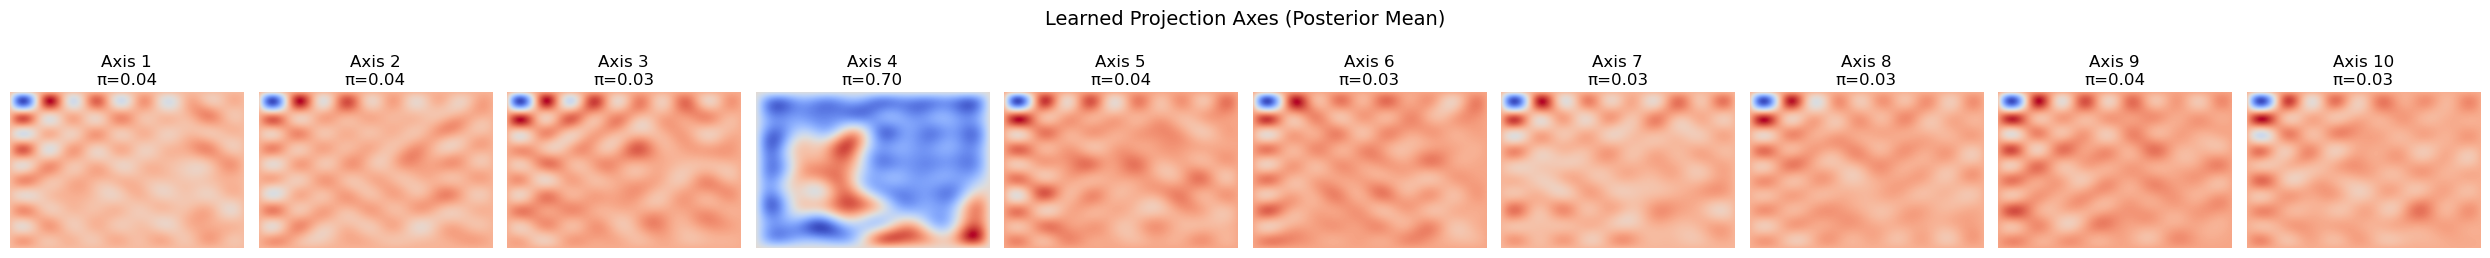

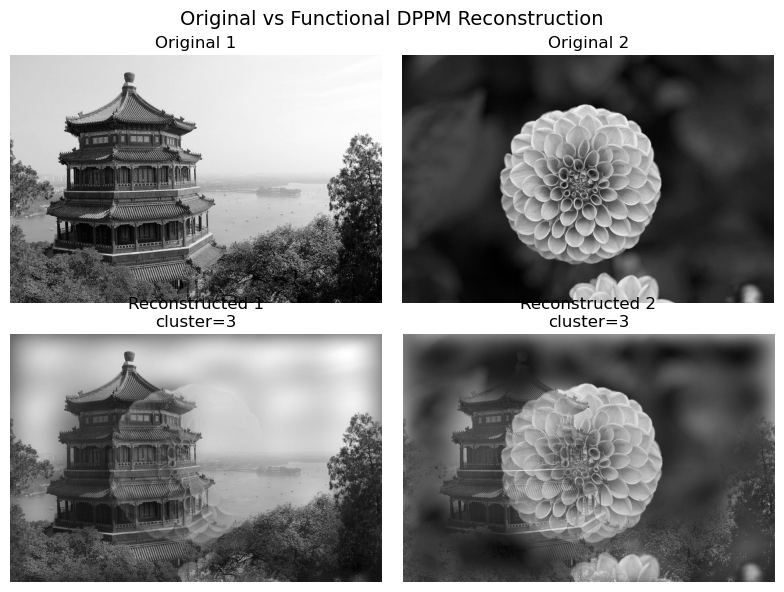

In [88]:

# ------------------------------------------------------------
# 4. Run functional DPPM on the two images
# ------------------------------------------------------------
K = 10  # truncation level / number of projection axes

sampler = EigenGP_DPPM_MCMC(
    X=X_normalized,          # (n_images, n_pixels)
    Phi=Phi_2D,              # (n_pixels, J_row*J_col)
    eigenvalues=eigenvalues_2D,
    K=K,
    alpha=1.0,
    a_tau=0.1, b_tau=0.1,
    a_sigma=0.1, b_sigma=0.1,
    sampler_type="collapsed",
    random_state=42,
)

print(f"\nRunning functional DPPM MCMC with K={K} on {n_images} images...")
samples = sampler.run(
    n_iter=1500,
    burn_in=750,
    thin=2,
    store_everything=True
)

n_kept = samples["G"].shape[0]
print(f"Collected {n_kept} posterior samples.")

# ------------------------------------------------------------
# 5. Summaries: projection axes & reconstructions
# ------------------------------------------------------------
G_mean = samples["G"].mean(axis=0)     # (n_pixels, K)
pi_mean = samples["pi"].mean(axis=0)
c_mode = np.round(samples["c"].mean(axis=0)).astype(int)
z_mean = samples["z"].mean(axis=0)     # (n_images,)

print("\nPosterior mixture weights (pi_mean):", pi_mean)
print("Modal cluster assignments:", c_mode)

# Visualize projection axes as images
fig, axes = plt.subplots(1, K, figsize=(2.5*K, 3))
fig.suptitle("Learned Projection Axes (Posterior Mean)", fontsize=14)

for k in range(K):
    g_k = G_mean[:, k].reshape(height, width, order="F")
    axes[k].imshow(g_k, cmap="coolwarm")
    axes[k].set_title(f"Axis {k+1}\nπ={pi_mean[k]:.2f}")
    axes[k].axis("off")

plt.tight_layout()
plt.show()

# Reconstruct images: X_i ≈ z_i * g_{c_i}
X_reconstructed = np.zeros_like(X_normalized)
for i in range(n_images):
    k = c_mode[i]
    X_reconstructed[i] = z_mean[i] * G_mean[:, k]

# Denormalize and reshape
X_recon_denorm = X_reconstructed * X_std + X_mean
reconstructed_images = X_recon_denorm.reshape(n_images, height, width, order="F")
original_images = X_flat.reshape(n_images, height, width, order="F")

fig, axes = plt.subplots(2, n_images, figsize=(4*n_images, 6))
fig.suptitle("Original vs Functional DPPM Reconstruction", fontsize=14)

for i in range(n_images):
    axes[0, i].imshow(original_images[i], cmap="gray")
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(reconstructed_images[i], cmap="gray")
    axes[1, i].set_title(f"Reconstructed {i+1}\ncluster={c_mode[i]}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

